In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [4]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend

'notebook'

In [9]:
PHONEME_PATH = '/cwork/ns458/BIDS-1.4_Phoneme_sequencing/BIDS/'
TIMIT_PATH = '/cwork/ns458/BIDS-1.0_TIMIT/BIDS/'
SENTENCE_PATH = '/cwork/ns458/BIDS-1.4_SentenceRep/BIDS/'
LEXICAL_PATH = '/cwork/ns458/BIDS-1.0_LexicalDecRepDelay/BIDS/'

In [10]:
# 获取每个数据集的subjects
def get_subjects(bids_path):
    """从BIDS目录获取所有subject ID"""
    path = Path(bids_path)
    subjects = sorted([d.name.replace('sub-', '') for d in path.iterdir() 
                      if d.is_dir() and d.name.startswith('sub-')])
    return set(subjects)

# 获取三个数据集的subjects
phoneme_subs = get_subjects(PHONEME_PATH)
timit_subs = get_subjects(TIMIT_PATH)
sentence_subs = get_subjects(SENTENCE_PATH)
lexical_subs = get_subjects(LEXICAL_PATH)

# 创建结构化DataFrame
all_subs = sorted(phoneme_subs | timit_subs | sentence_subs | lexical_subs)
df = pd.DataFrame({
    'subject': all_subs,
    'Phoneme': [s in phoneme_subs for s in all_subs],
    'TIMIT': [s in timit_subs for s in all_subs],
    'SentenceRep': [s in sentence_subs for s in all_subs],
    'Lexical': [s in lexical_subs for s in all_subs]
})

# 添加任务计数列
df['n_tasks'] = df[['Phoneme', 'TIMIT', 'SentenceRep', 'Lexical']].sum(axis=1)

print(f"Phoneme: {len(phoneme_subs)} subjects")
print(f"TIMIT: {len(timit_subs)} subjects")
print(f"SentenceRep: {len(sentence_subs)} subjects")
print(f"Lexical: {len(lexical_subs)} subjects")
print(f"Total unique: {len(all_subs)} subjects")
print(f"\\nDataFrame shape: {df.shape}")
df.head(10)

Phoneme: 50 subjects
TIMIT: 33 subjects
SentenceRep: 34 subjects
Lexical: 41 subjects
Total unique: 77 subjects
\nDataFrame shape: (77, 6)


,subject,Phoneme,TIMIT,SentenceRep,Lexical,n_tasks
0,D0005,False,False,True,False,1
1,D0007,False,False,True,False,1
2,D0008,False,False,True,False,1
3,D0009,False,False,True,False,1
4,D0015,False,False,True,False,1
5,D0016,False,False,True,False,1
6,D0017,False,False,True,False,1
7,D0018,False,False,True,False,1
8,D0019,True,False,False,False,1
9,D0020,False,False,True,False,1


In [11]:
total_subject_task = int(df['n_tasks'].sum())
print(f"Total subject-task instances (unique): {total_subject_task}")

Total subject-task instances (unique): 158


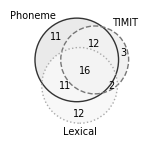

In [12]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

# 假设你的 cm 和 fontsize 已经定义好了
# cm = 1/2.54
# fontsize = 10 

fig, ax = plt.subplots(figsize=(4*cm, 4*cm))

# --- 关键修改 1: 基础 Venn 图设为全透明 ---
# set_colors 这里其实不重要了，因为 alpha=0，但为了逻辑统一还是留着
# 重点是 alpha=0，把填充色彻底“关掉”
v = venn3([phoneme_subs, timit_subs, lexical_subs], 
          set_labels=('Phoneme', 'TIMIT', 'Lexical'),
          set_colors = ('#333333', '#777777', '#BBBBBB'), 
          alpha=0.1,  # <--- 这里改成 0，变成透明
          ax=ax)


# --- 关键修改 2: 增强圆圈边框 (Outlines) ---
# 我们用不同深浅的灰色边框来区分数据集
# linestyle 可以增加区分度，防止黑白打印分不清
c = venn3_circles([phoneme_subs, timit_subs, lexical_subs], 
                  linewidth=1, # 稍微加粗一点点，0.75可能太细
                  ax=ax)

c[0].set_edgecolor('#333333') # Phoneme - 深灰
c[1].set_edgecolor('#777777') # TIMIT - 中灰
c[2].set_edgecolor('#AAAAAA') # SentenceRep - 浅灰

# 可选：如果你想更进一步区分，可以给不同的圈设置不同的线型
c[0].set_linestyle('-')      # 实线
c[1].set_linestyle('--')     # 虚线
c[2].set_linestyle(':')      # 点线

# --- 字体设置保持不变 ---
for text in v.set_labels:
    if text:
        text.set_fontsize(fontsize)
        text.set_color('#000000') 

for text in v.subset_labels:
    if text:
        text.set_fontsize(fontsize)
        text.set_color('#000000')


plt.savefig('../img/fig1/task.svg', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()